# RSA analysis of the Neuropixel Data

This notebook analyzes Allen Institute's Neuropixel data. It focuses on the `functional_connectivity` dataset since that dataset seems to be richer (more repeats of the same stimuli), with more rest time in-between sessions, and has better quality data (only one animal missing pupilometry measurements).

In [117]:
from src.neuropixel import Neuropixel
from src.utils import *

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# HOME = Path('/media/internal/projects/Allen/Ecephys')
HOME = Path('D:\Allen\Ecephys')
npx = Neuropixel(HOME)

In [3]:
data_type = 'functional_connectivity'

## Natural Movie 1

This movie is played in both sessions of `functional_connectivity`, each repeated 60 times on each session (there are also 20 repeats with temporal shuffle that I'm going to ignore for now). The movie has 30s duration, so I will extract 30 "blocks" of 1s duration.

Let's start by getting the dataframes for each of these blocks.

In [4]:
table = npx.cache.get_session_table()

In [7]:
# load into one dataframe
files = npx.SAVE_DIR.glob('*.csv')
# data_files = sorted(list(files))  # sort and list the files
data_files = sorted([f for f in files if data_type in f.name][:2])  # sort and list the files
df = pd.concat(map(lambda f: pd.read_csv(f, index_col=0), data_files), ignore_index=True)

In [8]:
df

,stimulus_presentation_id,unit_id,start_time,stop_time,stimulus_block,stimulus_name,stimulus_condition_id,repeat,spike_counts,subject,roi,movie_sec,median_speed,mean_speed,pupil_area
0,4339,950950049,2297.212884,2297.246246,3.0,natural_movie_one_more_repeats,282,1.0,4,766640955,VISrl,1,1.126390,1.506786,0.001078
1,4339,950950095,2297.212884,2297.246246,3.0,natural_movie_one_more_repeats,282,1.0,2,766640955,VISrl,1,1.126390,1.506786,0.001078
2,4339,950950120,2297.212884,2297.246246,3.0,natural_movie_one_more_repeats,282,1.0,7,766640955,VISrl,1,1.126390,1.506786,0.001078
3,4339,950950182,2297.212884,2297.246246,3.0,natural_movie_one_more_repeats,282,1.0,32,766640955,VISrl,1,1.126390,1.506786,0.001078
4,4339,950950194,2297.212884,2297.246246,3.0,natural_movie_one_more_repeats,282,1.0,32,766640955,VISrl,1,1.126390,1.506786,0.001078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
971995,76911,950947983,8301.259458,8301.292818,8.0,natural_movie_one_more_repeats,1152,60.0,2,767871931,VISal,30,1.345067,1.573845,0.001245
971996,76911,950948097,8301.259458,8301.292818,8.0,natural_movie_one_more_repeats,1152,60.0,10,767871931,VISal,30,1.345067,1.573845,0.001245
971997,76911,950948114,8301.259458,8301.292818,8.0,natural_movie_one_more_repeats,1152,60.0,2,767871931,VISal,30,1.345067,1.573845,0.001245
971998,76911,950948574,8301.259458,8301.292818,8.0,natural_movie_one_more_repeats,1152,60.0,0,767871931,VISal,30,1.345067,1.573845,0.001245


In [91]:
subs = df.subject.unique()
rois = df.roi.unique()
chunks = df.movie_sec.unique()
repeats = df.repeat.unique()
blocks = df.stimulus_block.unique()

## 1.1 Within-block

In [106]:
roi = 'VISp'
block = 3
visp_rdm = np.zeros((len(chunks), len(chunks)))
# time_bins = np.arange(1, len(chunks) + 1)
time_bins = np.arange(1, len(chunks) + 1)
repeats = repeats[:30]

all_mats = {}
for sub in subs:
    print(f"Subject: {sub}")
    n_units = len(df.loc[(df.subject==sub) & (df.roi == roi), "unit_id"].unique())
    sub_mat = np.zeros((len(repeats), len(chunks), n_units))

    for r, repeat in enumerate(repeats):
        # print(f"Repeat: {repeat}")

        for c, chunk in enumerate(chunks):
            # print(f"Bin: {chunk}")
            pv = df.loc[(df.subject == sub) & (df.roi == roi) & (df.movie_sec == chunk) & (df.repeat == repeat) & (df.stimulus_block == block), "spike_counts"]
            np.sort(pv)

            try:
                sub_mat[r][c] = pv
            except ValueError:
                print(f"Repeat {repeat} chunk {chunk} PV has dims {pv.shape} which doesn't match {n_units}. Populating with NaNs.")
                pv = np.repeat(np.nan, n_units)
    all_mats[sub] = sub_mat

Subject: 766640955
Subject: 767871931


<AxesSubplot:>

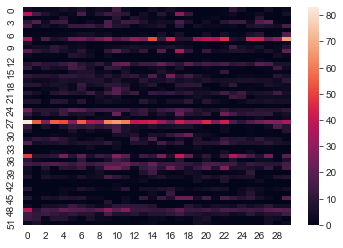

In [107]:
sns.heatmap(all_mats[766640955][4].T)

In [108]:
sim = calc_similarity(all_mats[766640955])

In [109]:
corrs_s, angles_s  = sim

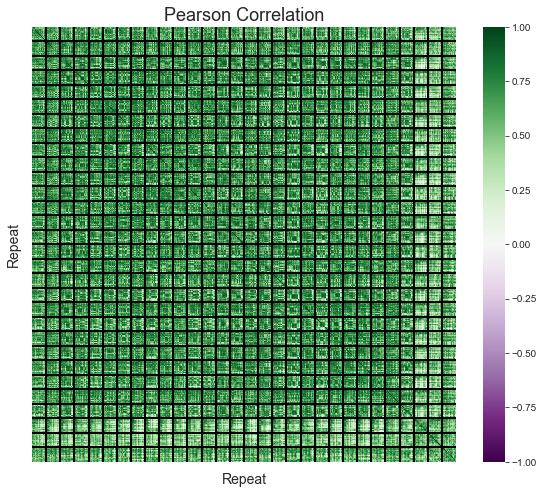

In [115]:
plot_corr(corrs_s, n_repeat_plot= 30)

UnboundLocalError: local variable 'tick_labels' referenced before assignment

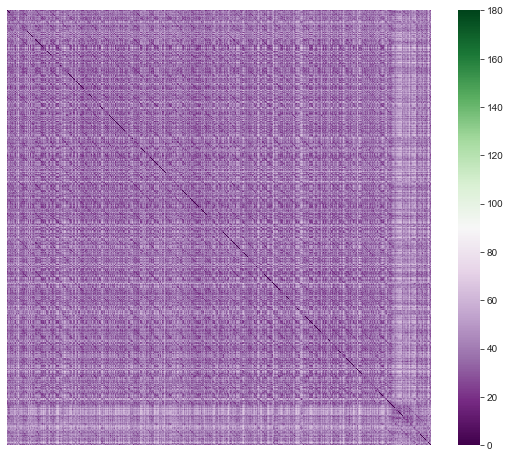

In [111]:
plot_angle(angles_s, n_repeat_plot= 30)

In [75]:
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import TSNEdd

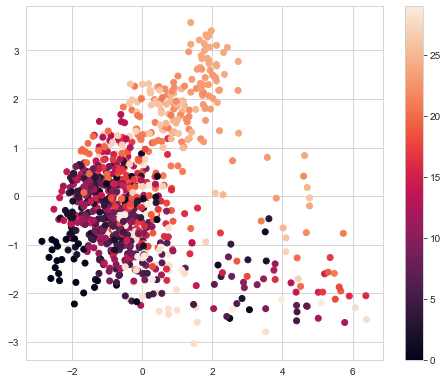

In [79]:
pca = PCA()
Xt_pca = pca.fit_transform(corrs_s)
label_stimuli = list(range(30))*30

plot_2D(Xt_pca, label = label_stimuli)

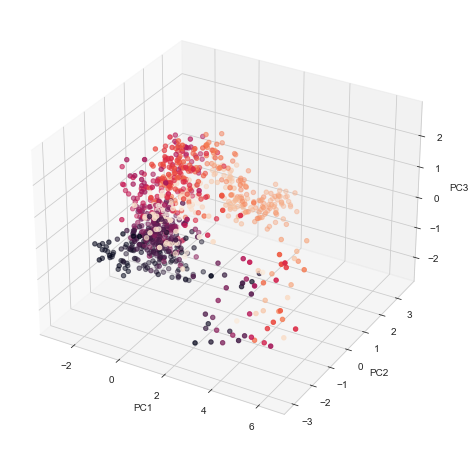

In [80]:
plot_3D(Xt_pca, label = label_stimuli)

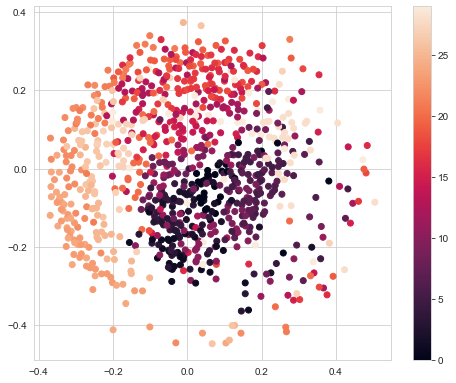

In [81]:
nmds = MDS(random_state= 1693, dissimilarity='precomputed')
Xt_mds =  nmds.fit_transform(1- corrs_s)
plot_2D(Xt_mds, label = label_stimuli)

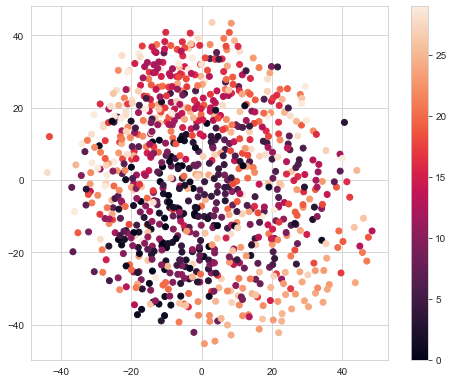

In [82]:

nmds_angle = MDS(random_state= 1693, dissimilarity='precomputed')
Xt_mds_angle =  nmds_angle.fit_transform(angles_s)
plot_2D(Xt_mds_angle, label = label_stimuli)

C:\Users\shari\miniconda3\envs\neuro\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\shari\miniconda3\envs\neuro\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


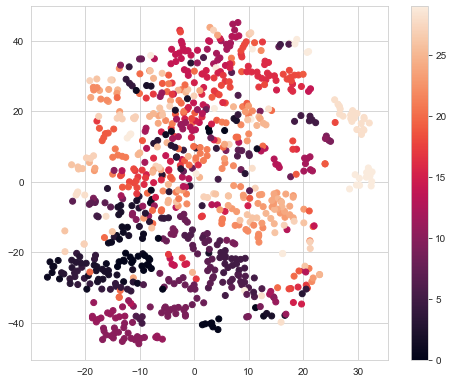

In [116]:
tsne = TSNE(n_components=2)
vals_s_long = np.reshape(all_mats[766640955], (900, all_mats[766640955].shape[-1]))

Xtsne = tsne.fit_transform(vals_s_long)
plot_2D(Xtsne, label = label_stimuli)